In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import bartz
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
from stochtree import BARTModel
import time

## Triazines

In [2]:
from sklearn.datasets import fetch_openml

# Triazines dataset from UCI
triazines = fetch_openml(name='triazines', version=1, as_frame=True)
X = triazines.data
y = triazines.target

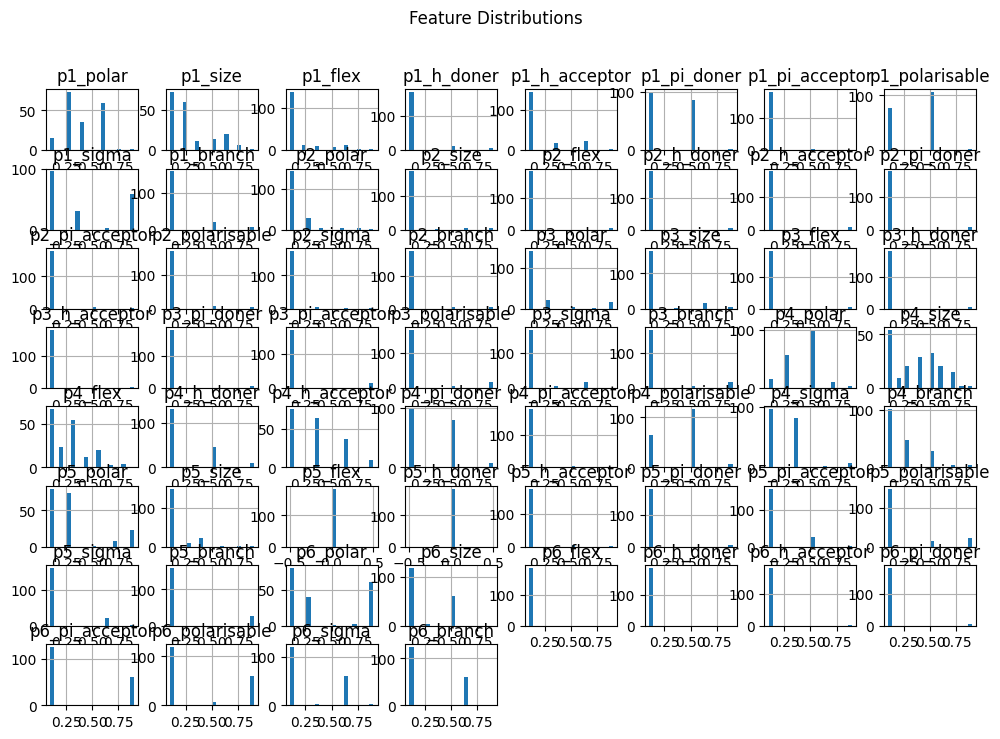

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

X.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

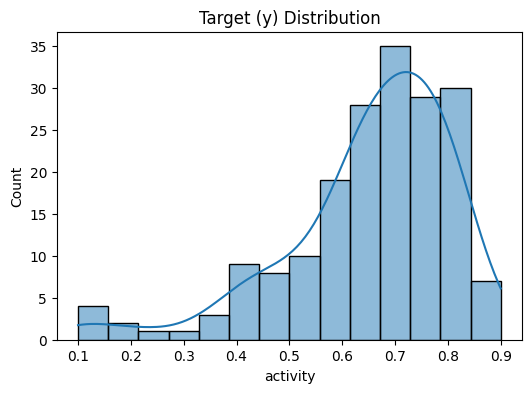

In [4]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

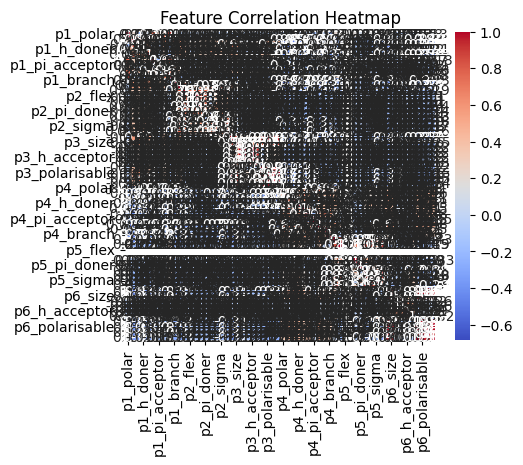

In [5]:
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [7]:
import comparison
import pandas as pd

rhat_df = comparison.gelman_rubin_r_compare(X, y, n_runs=5, n_chains=4, ndpost=1000, nskip=1000, n_trees=100, n_jobs=5)
mean_row = pd.DataFrame([rhat_df.mean()], index=["mean"])
std_row = pd.DataFrame([rhat_df.std()], index=["std"])
rhat_df_with_stats = pd.concat([rhat_df, mean_row, std_row])
print("Gelman-Rubin R̂ comparison matrix:")
print(rhat_df_with_stats)

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


Gelman-Rubin R̂ comparison matrix:
      MultiBART_Rhat_Sigma2  DefaultBART_Rhat_Sigma2  MultiBART_Rhat_RMSE  \
0                  1.010209                 1.008128             1.012173   
1                  1.006424                 1.000228             1.000904   
2                  1.002798                 1.006653             1.001718   
3                  1.011701                 1.023599             1.002138   
4                  1.004030                 1.004763             1.000617   
mean               1.007032                 1.008674             1.003510   
std                0.003847                 0.008857             0.004881   

      DefaultBART_Rhat_RMSE  
0                  1.008709  
1                  1.005359  
2                  1.007352  
3                  1.003872  
4                  1.001083  
mean               1.005275  
std                0.002985  


In [8]:
rhat_df.to_csv("results/real8_Triazines_rhat.csv", index=False)

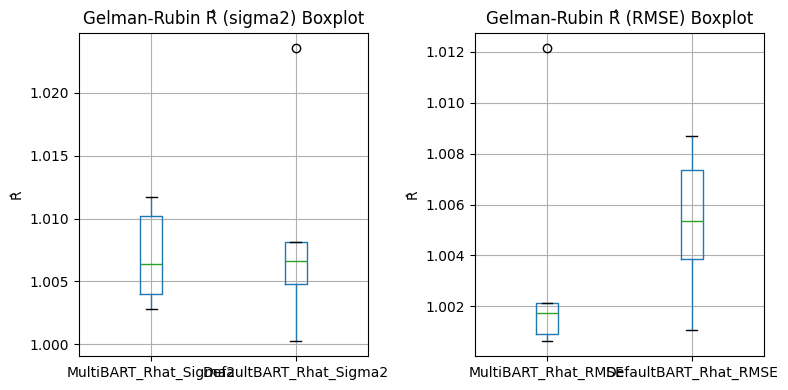

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# sigma2 boxplot
rhat_df[["MultiBART_Rhat_Sigma2", "DefaultBART_Rhat_Sigma2"]].boxplot(ax=axes[0])
axes[0].set_title("Gelman-Rubin R̂ (sigma2) Boxplot")
axes[0].set_ylabel("R̂")

# rmse boxplot
rhat_df[["MultiBART_Rhat_RMSE", "DefaultBART_Rhat_RMSE"]].boxplot(ax=axes[1])
axes[1].set_title("Gelman-Rubin R̂ (RMSE) Boxplot")
axes[1].set_ylabel("R̂")

plt.tight_layout()
plt.show()

c:\Learning\Phd\BART\bartpy\bart_env\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


test_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.020220  0.020129  0.020500  0.020100  0.022165
1      0.014914  0.015676  0.016704  0.010456  0.008847
2      0.015405  0.015547  0.016166  0.015804  0.022521
3      0.014693  0.015109  0.015372  0.019007  0.027133
4      0.014161  0.014172  0.014538  0.016437  0.018578
5      0.022945  0.024118  0.026063  0.019980  0.023882
6      0.012873  0.012944  0.012565  0.019972  0.022427
7      0.017507  0.018203  0.019013  0.017551  0.017660
8      0.011413  0.011093  0.011470  0.007863  0.010011
9      0.009495  0.009608  0.010183  0.009424  0.013731
mean   0.015363  0.015660  0.016257  0.015659  0.018695
std    0.004000  0.004287  0.004704  0.004704  0.006118



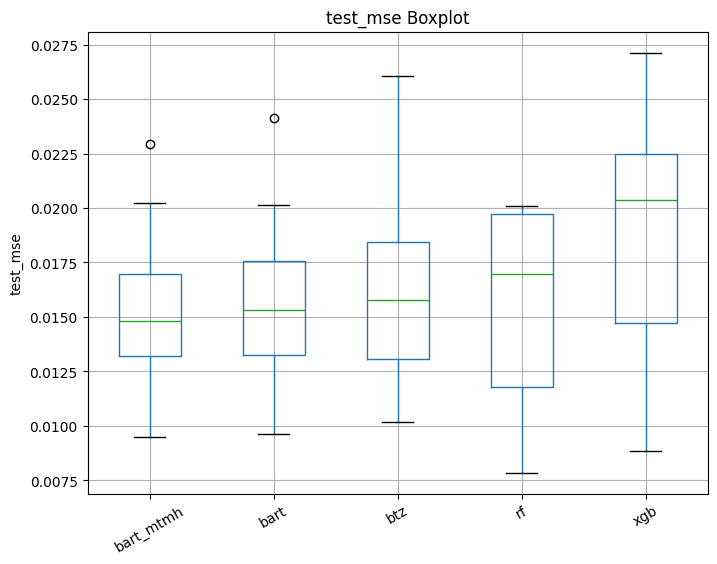

train_mse:
      bart_mtmh      bart       btz        rf       xgb
0      0.010032  0.010566  0.011298  0.001889  0.000017
1      0.012474  0.013209  0.014471  0.002761  0.000335
2      0.011118  0.012057  0.013332  0.002411  0.000320
3      0.011647  0.012718  0.013760  0.001884  0.000047
4      0.013018  0.013848  0.014092  0.002145  0.000333
5      0.009745  0.010635  0.012255  0.002086  0.000362
6      0.011807  0.012532  0.014201  0.001827  0.000055
7      0.009989  0.011090  0.012197  0.002243  0.000323
8      0.014263  0.015301  0.015769  0.003117  0.000359
9      0.013550  0.014717  0.015293  0.002526  0.000072
mean   0.011764  0.012667  0.013667  0.002289  0.000222
std    0.001570  0.001641  0.001417  0.000419  0.000151



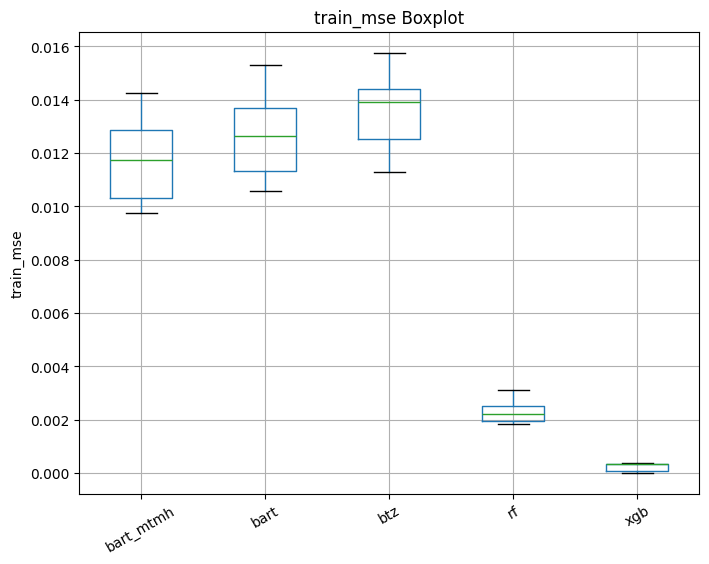

pi_length:
      bart_mtmh      bart       btz
0      0.486436  0.486717  0.496278
1      0.539878  0.540482  0.541013
2      0.511730  0.514724  0.524986
3      0.527354  0.533769  0.531858
4      0.542102  0.556891  0.538096
5      0.490921  0.488948  0.500163
6      0.522429  0.526673  0.540392
7      0.491698  0.504871  0.508372
8      0.564698  0.571483  0.563095
9      0.559412  0.575119  0.565509
mean   0.523666  0.529968  0.530976
std    0.028288  0.031690  0.023957



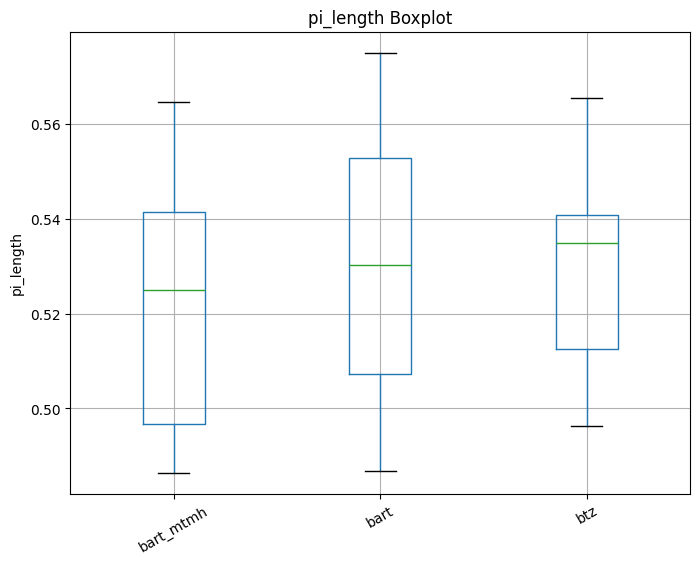

coverage:
      bart_mtmh      bart       btz
0      0.893617  0.914894  0.893617
1      0.936170  0.936170  0.936170
2      0.957447  0.957447  0.957447
3      0.914894  0.914894  0.936170
4      0.957447  0.957447  0.978723
5      0.893617  0.914894  0.893617
6      0.957447  0.978723  0.978723
7      0.936170  0.936170  0.936170
8      0.978723  0.978723  0.978723
9      0.957447  1.000000  1.000000
mean   0.938298  0.948936  0.948936
std    0.029156  0.030422  0.036440



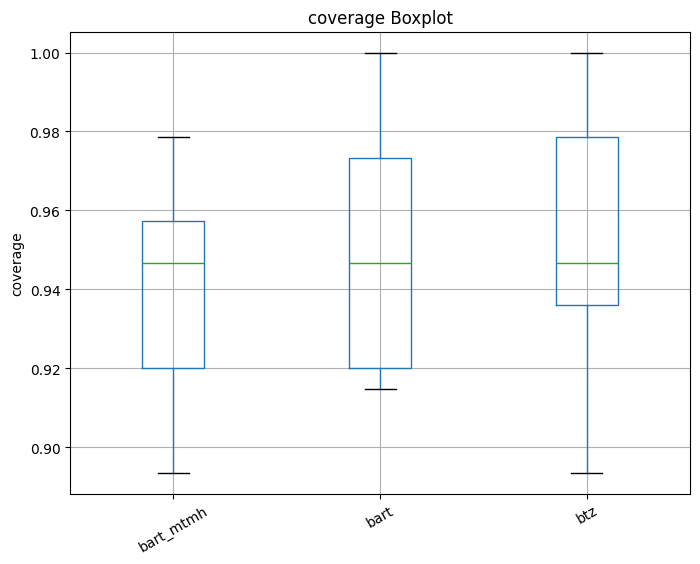

train_time:
      bart_mtmh       bart        btz        rf       xgb
0     55.273328  12.008622  30.434249  0.167948  0.354139
1     55.407049  12.045664  30.274630  0.165316  0.344628
2     55.078113  12.039259  30.791675  0.210925  0.252528
3     55.220777  11.883537  30.696247  0.155890  0.306857
4     55.751940  11.998681  31.873250  0.127780  0.190265
5     57.283953  12.288915  27.933863  0.409319  0.325596
6     56.585263  12.018284  27.005494  0.824092  0.641532
7     57.220604  12.200030  29.328724  0.266172  0.354162
8     56.907418  12.331077  30.959221  0.124954  0.183013
9     56.481076  12.244041  31.461880  0.111634  0.175058
mean  56.120952  12.105811  30.075923  0.256403  0.312778
std    0.868443   0.148434   1.548143  0.218282  0.136285



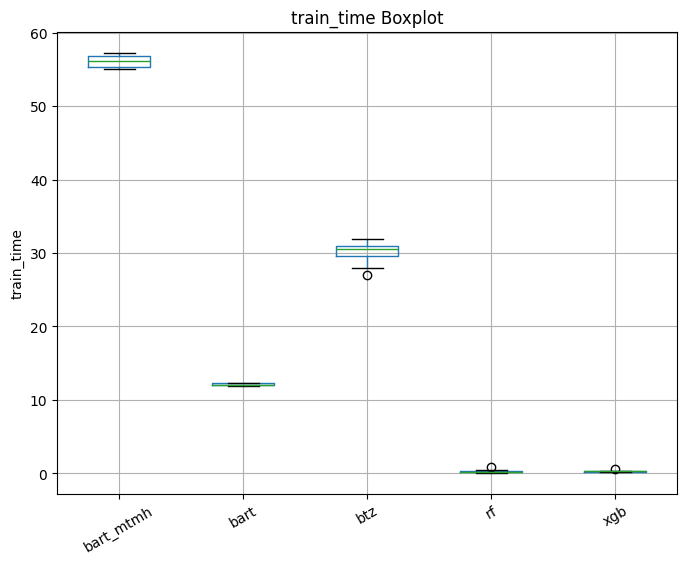

In [10]:
import matplotlib.pyplot as plt
import comparison
import pandas as pd

mse_results = comparison.bart_mse_comparison(X, y, n_runs=10, n_skip=1000, n_post=1000, n_trees=100, n_jobs=5)
for k, v in mse_results.items():
    mean_row = pd.DataFrame([v.mean()], index=["mean"])
    std_row = pd.DataFrame([v.std()], index=["std"])
    v_with_stats = pd.concat([v, mean_row, std_row])
    print(f"{k}:\n{v_with_stats}\n")
    
    plt.figure(figsize=(8, 6))
    v.boxplot()
    plt.title(f"{k} Boxplot")
    plt.ylabel(k)
    plt.xticks(rotation=30)
    plt.show()

In [11]:
for k, v in mse_results.items():
    csv_name = f"results/real8_Triazines_{k}.csv"
    v.to_csv(csv_name, index=False)

## Multi-tries

In [12]:
from multi_tries import multi_tries_performance
import pandas as pd

csv_path = "results/real8_Triazines_tries.csv"
existing_df = None

if os.path.exists(csv_path):
    existing_df = pd.read_csv(csv_path)

df = multi_tries_performance(
    X, y,
    multi_tries_list=[1, 5, 10, 50, 100],
    n_runs=5, n_chains=4,
    ndpost=1000, nskip=1000, n_trees=100, n_jobs=5
)

if existing_df is not None:
    df = pd.concat([existing_df, df], ignore_index=True)
    df = df.sort_values(by='multi_tries', ascending=True).reset_index(drop=True)

df.to_csv("results/real8_Triazines_tries.csv", index=False)

In [13]:
print(df)

   multi_tries  Rhat_Sigma2  Rhat_RMSE  Test_MSE  Coverage  Train_Time
0            1     1.016066   1.004706  0.016382  0.940426   22.553079
1            5     1.007603   1.003451  0.015933  0.931915   36.334390
2           10     1.007032   1.003510  0.016007  0.931915   54.526771
3           50     1.012920   1.008426  0.015773  0.940426  216.241776
4          100     1.021569   1.005264  0.015918  0.940426  483.767630
